mineral imagery using ASTER data

## Mineral imagery from ASTER data in the Cloud using Cloud Optimized Geotiffs (COG) from AWS s3 bucket.
### Data Used in the Example  

SWIR []
NIR []
TIR []

---

### Import Packages <a id="1.1"></a>

Import the required packages and set the input/working directory to run this Jupyter Notebook locally.

In [1]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from osgeo import gdal
import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.session import AWSSession
import pyproj
from pyproj import Proj
from shapely.ops import transform
import xarray as xr
import geoviews as gv
from cartopy import crs
import hvplot.xarray
import holoviews as hv


In [2]:
# Set Up Working Environment
inDir = os.getcwd()
os.chdir(inDir)

---

In [3]:
# Bring in the farm field region of interest
field = gp.read_file('Field_Boundary.geojson')
field

DriverError: Field_Boundary.geojson: No such file or directory

Plot the geometry of the farm field boundaries.

In [ ]:
fieldShape = field['geometry'][0] # Define the geometry as a shapely polygon
fieldShape

Below, combine a plot of the farm field boundary (combine two `geoviews` plots using `*`) with a basemap layer.

The farm field used in this example use case is located northwest of Chico, CA. 

Now, add the bounding box of the region of interest to the CMR-STAC API Search query using the `bbox` parameter.

In [ ]:
bbox = f'{fieldShape.bounds[0]},{fieldShape.bounds[1]},{fieldShape.bounds[2]},{fieldShape.bounds[3]}'    # Defined from ROI bounds
params['bbox'] = bbox                                                                                    # Add ROI to params
params

In [ ]:
search_response = r.post(lp_search, json=params).json()    # Send POST request with bbox included
print(f"{len(search_response['features'])} items found!")

---

## 4. Get ASTER data from AWS s3 bucket ( Cloud )

In this section, configure `gdal` and `rasterio` to use `vsicurl` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

In [5]:
######
# Read COG from AWS s3 bucket
######

aws_session = AWSSession(region_name='us-west-2', aws_unsigned=True)
# print('AWS credentials: ',aws_session.credentials, '\n', 'AWS unsigned: ', aws_session.unsigned)
with rio.Env(aws_session):
    cog = rio.open('s3://aster-l1t/SWIR/32611/137/568/20080101/AST_L1T_00301012008054749_20170730074450_36729_SWIR.tif')
print(cog.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2848, 'height': 2542, 'count': 6, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 519195.0,
       0.0, -30.0, 3858675.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


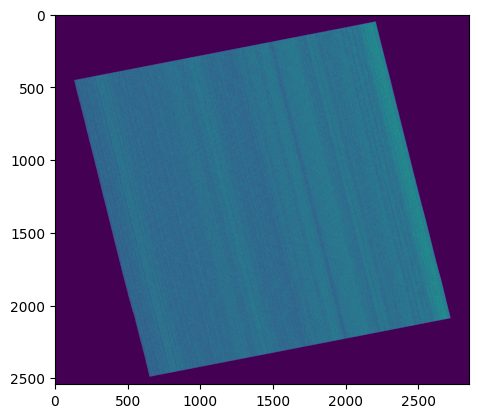

In [6]:
imshow(cog.read(1))

Below, take the farm field `shapely` polygon and convert it from lat/lon (EPSG: 4326) into the [native projection of HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). This must be done in order to use the Region of Interest (ROI) to subset the COG that is being pulled into memory--it must be in the native projection of the data being extracted. 

In [40]:
geo_CRS = Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)  # Source coordinate system of the ROI
utm = pyproj.Proj(nir.crs)                                                  # Destination coordinate system
project = pyproj.Transformer.from_proj(geo_CRS, utm)                        # Set up the transformation
fsUTM = transform(project.transform, fieldShape)                            # Apply reprojection

Now, we can use the ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [41]:
nir_array, nir_transform = rio.mask.mask(nir, [fsUTM], crop=True)  # Extract the data for the ROI and clip to that bbox

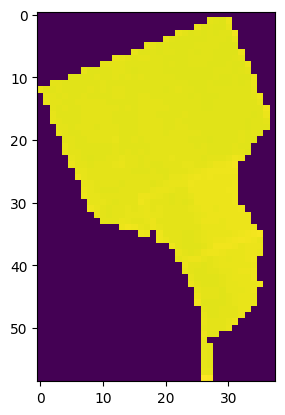

In [44]:
plt.imshow(nir_array[0]);  # Quick visual to assure that it worked
# plt.show()

Above, you can see that the data have been loaded into memory already subset to our ROI. Next, load in the red and blue bands.

In [45]:
red_array, _ = rio.mask.mask(red,[fsUTM],crop=True)
blue_array, _ = rio.mask.mask(blue,[fsUTM],crop=True)
print('Data is loaded into memory!')

Data is loaded into memory!


In [46]:
del a, e, evi_band_links, evi_bands  # Remove variables that are no longer needed

Looking at the table above, using the left column, you can see there are 7 bitwords, or bit groupings for this quality layer. Below, set the number of bitwords and the number of bits per bitword.